In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from tensorboardX import SummaryWriter

import os
import argparse
import pandas as pd
import random
import numpy as np

from others.datasets import get_dataset
from models import *
import others.bounds as bounds
from others.utils_practical import *


device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('==========', device)

========== cuda


In [2]:
def train(trainloader, net, epoch, optimizer, scheduler, criterion, writer=None, model_path="./checkpoints/", width_list=[None], new_sedghi=False, lip4conv=False, gouk_correct=False):
    print('\nEpoch: %d' % epoch)
    global count_setp
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    batch_idx = -1

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)

        reg_loss_conv = torch.tensor([0.0], requires_grad=True).to(device=loss.device)
        
        ############################# lip4conv:
        if lip4conv:
            for (kernel, input_size) in net.get_all_kernels():
                bound = bounds.estimate(
                    kernel,
                    n=input_size[0],
                    name_func="ours_backward",
                    n_iter=6,
                )
                reg_loss_conv = reg_loss_conv + F.threshold(
                    bound, 1.0, 0.0
                )

            reg_loss_conv = 0.1 * reg_loss_conv
        #############################

        loss = loss + reg_loss_conv
        loss.backward()
        optimizer.step()

        ############################# Gouk method:
        if gouk_correct and (count_setp > 0 or epoch != 0):# and count_setp % 100 == 0:

            with torch.no_grad():
                constrain_conv(
                    net,
                    mode='divide-by-largest',
                    conv_clip_assign_value=1,
                    linear_clip_assign_value=1,
                    iterations=5,
                    orthogonal=-1,
                    outputs=width_list,
                )
        #################

        ########################## Senderovich (nsedghi):
        if new_sedghi and (count_setp > 0 or epoch != 0) and count_setp % 100 == 0:

            with torch.no_grad():
                constrain_conv(
                    net,
                    mode='clip',
                    conv_clip_assign_value=1,
                    linear_clip_assign_value=1,
                    orthogonal=-1,
                    outputs=width_list,
                )
        #################


        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        count_setp += 1

    writer.add_scalar('train/acc', 100.*correct/total, epoch)
    writer.add_scalar('train/loss', train_loss/(batch_idx+1), epoch)

    print('train/acc', 100.*correct/total)
    print('train/loss', train_loss/(batch_idx+1))

    scheduler.step()

    state = {
        'net': net.state_dict(),
        'epoch': epoch,
        'scheduler': scheduler.state_dict(),
        'optimizer': optimizer.state_dict(),
    }
    torch.save(state, model_path)

    return train_loss/(batch_idx+1), 100.*correct/total


def test(testloader, net, epoch, criterion, optimizer, scheduler, writer=None, model_path="./checkpoints/"):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    batch_idx = -1
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        best_acc = acc
        state = {
            'net': net.state_dict(),
            'acc': acc,
            'epoch': epoch,
            'scheduler': scheduler.state_dict(),
            'optimizer': optimizer.state_dict(),
        }
        torch.save(state, model_path)


    writer.add_scalar('test/acc', 100.*correct/total, epoch)
    writer.add_scalar('test/loss', test_loss/(batch_idx+1), epoch)

    print(' Test acc', 100.*correct/total)

    return test_loss/(batch_idx+1), 100.*correct/total

In [3]:
def main(trainloader, testloader, method='fastclip', in_chan=1, kernel_size=3, padding=0, stride=1, dilation=1, padding_mode='zeros', lin_layer=None, outdir = 'simpleConv/', epochs=120):
    # lin_layer = 36864 #k5: 36864 #k3: 43264

    clip_flag    = False
    new_sedghi   = False
    miyato_flag  = False
    gouk_correct = False
    lip4conv     = False
    orig_flag    = False

    if method[:4] == 'fast':
        clip_flag    = True
    elif method == 'catclip':
        clip_flag    = True
    elif method == 'nsedghi':
        new_sedghi   = True
    elif method == 'miyato':
        miyato_flag  = True
    elif method == 'gouk':
        gouk_correct = True
    elif method == 'lip4conv':
        lip4conv     = True
    elif method == 'orig':
        orig_flag    = True
    else:
        print('unknown method!')
        exit(0)

    bn_flag = True
    kernel_size = kernel_size
    stride = stride
    padding = padding
    dilation = dilation
    padding_mode = padding_mode
    lin_layer = lin_layer

    outdir = outdir + method + '_model_k' + str(kernel_size) + '_p' + str(padding) + '_st' + str(stride) + '_di' + str(dilation) + '_pad_' + padding_mode + '/'

    if not os.path.exists(outdir):
        os.makedirs(outdir)

    print('------------> Output Directory: ', outdir)
    writer = SummaryWriter(outdir)

    df = None
    if miyato_flag:
        print('other methods are used!')
        net = simpleConv_miyato(in_chan=in_chan, device=device, clip_flag=clip_flag, clip_opt_iter=1, summary=True, bn=bn_flag, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, padding_mode=padding_mode, lin_layer=lin_layer)
    elif new_sedghi or gouk_correct or orig_flag or lip4conv:
        print('other methods are used!')
        net = simpleConv_orig(in_chan=in_chan, device=device, clip_flag=clip_flag, clip_opt_iter=1, summary=True, bn=bn_flag, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, padding_mode=padding_mode, lin_layer=lin_layer) 
    elif clip_flag:
        net = simpleConv(concat_sv=True, in_chan=in_chan, device=device, clip_flag=True, clip_opt_iter=5, summary=True, clip=1., writer=writer, bn=bn_flag, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, padding_mode=padding_mode, lin_layer=lin_layer) 

    model_path =  outdir + 'ckpt.pth'
    model_path_test =  outdir + 'ckpt_best_test.pth'

    net = net.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1)

    tr_loss_list = []
    tr_acc_list = []
    ts_loss_list = []
    ts_acc_list = []
    sv_list = []

    conv_outputs = []
    if new_sedghi or gouk_correct:
        conv_outputs = get_conv_output_shapes(net, (1,28,28))

    for epoch in range(epochs):
        tr_loss, tr_acc = train(trainloader, net, epoch, optimizer, scheduler, criterion, writer=writer, model_path=model_path, width_list=conv_outputs, new_sedghi=new_sedghi, lip4conv=lip4conv, gouk_correct=gouk_correct)
        ts_loss, ts_acc = test(testloader, net, epoch, criterion, optimizer, scheduler, writer=writer, model_path=model_path_test)

        net.zero_grad()
        idx = 0
        for (m_name, m) in net.named_modules():
            if isinstance(m, (torch.nn.Linear, torch.nn.Conv2d)):
                if idx > 0:
                    continue
                VT_shape = [1, 1, 28, 28]
                if idx == 1:
                    VT_shape = [1, 64, 28, 28]
                x0 = torch.randn(VT_shape, device=device)
                const = 'Conv2d_' + str(idx)

                qr = power_qr(lambda x: m(x) - m(torch.zeros_like(x)), x0.clone().detach(), n_iters=1000, device=device)

                writer.add_scalar('train/lsv_' + const, qr[-1][0], epoch)
                sv_list.append(qr[-1][0].item())
                print('largest SV of ' + const, qr[-1][0].item())
                idx += 1


        tr_loss_list.append(tr_loss)
        tr_acc_list.append(tr_acc)
        ts_loss_list.append(ts_loss)
        ts_acc_list.append(ts_acc)

        writer.add_scalar('test/best_acc', best_acc, epoch)

    df = pd.DataFrame({'tr_loss': tr_loss_list, 'tr_acc': tr_acc_list, 'ts_loss': ts_loss_list, 'ts_acc': ts_acc_list, 'SV': sv_list})
    df.to_csv(outdir + 'results.csv')
    
    return df

In [7]:
seed_list = [10**i for i in range(5)]
seed = seed_list[0]

epochs = 120

best_acc = 0  # best test accuracy
count_setp = 0

seed_val = seed
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
np.random.seed(seed_val)
random.seed(seed_val)

trainset = get_dataset('mnist', 'train')
testset = get_dataset('mnist', 'test')
trainloader = torch.utils.data.DataLoader(trainset, shuffle=True, batch_size=128, num_workers=1)
testloader = torch.utils.data.DataLoader(testset, shuffle=False, batch_size=128, num_workers=1)

##### settings of the convolutional layer:
kernel_size = 3
stride = 1
padding = 1
dilation = 1
lin_layer = None
padding_mode = 'reflect'

method = 'fastclip'  ### ---> choose one of these clipping methods = ['fastclip', 'nsedghi', 'miyato', 'gouk', 'lip4conv', 'orig']
### orig: original model without clipping, 
### fastclip: our method,
### lip4conv: Delattre et al. (2023),
### nsedghi: Senderovich et al. (2022),
### gouk: Gouk et al. (2021),
### miyato: Miyato et al. (2018)

results_df = main(trainloader, testloader, 
                    method=method, epochs=epochs, kernel_size=kernel_size, 
                    stride=stride, padding=padding, dilation=dilation, 
                    padding_mode=padding_mode, lin_layer=lin_layer)


------------> Output Directory:  simpleConv/fastclip_model_k3_p1_st1_di1_pad_reflect/
cocant sv is being recorded!
!!!!!!! Clipping is active !!!!!!!! clip val:  1.0

Epoch: 0
train/acc 87.07
train/loss 0.403339290828593
 Test acc 92.97
largest SV of Conv2d_0 1.893099069595337

Epoch: 1
train/acc 92.315
train/loss 0.23934928089507354
 Test acc 94.47
largest SV of Conv2d_0 1.2353582382202148

Epoch: 2
train/acc 93.80166666666666
train/loss 0.19593507969684437
 Test acc 93.57
largest SV of Conv2d_0 1.0937789678573608

Epoch: 3
train/acc 94.37666666666667
train/loss 0.17539547415557447
 Test acc 93.93
largest SV of Conv2d_0 1.079450011253357

Epoch: 4
train/acc 94.71833333333333
train/loss 0.1650073821070606
 Test acc 94.23
largest SV of Conv2d_0 1.0809744596481323

Epoch: 5
train/acc 95.07333333333334
train/loss 0.152522298803271
 Test acc 94.43
largest SV of Conv2d_0 1.0693864822387695

Epoch: 6
train/acc 95.37
train/loss 0.14588199107091565
 Test acc 94.74
largest SV of Conv2d_0 1.0780

    tr_loss     tr_acc   ts_loss  ts_acc        SV
0  0.403339  87.070000  0.230342   92.97  1.893099
1  0.239349  92.315000  0.183566   94.47  1.235358
2  0.195935  93.801667  0.198700   93.57  1.093779
3  0.175395  94.376667  0.193428   93.93  1.079450
4  0.165007  94.718333  0.178349   94.23  1.080974


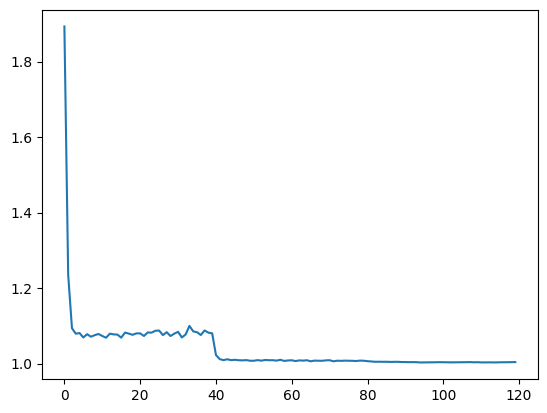

In [8]:
print(results_df.head())
plt.plot(results_df.index, results_df['SV'], label='Spectral Norm')

In [7]:
%load_ext tensorboard

In [8]:
%tensorboard --logdir simpleConv/fastclip_model_k3_p0_st1_di1_pad_reflect/ 